# Word2Vec

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

Датасет из рецептов: 
- берем только тексты, разметка не нужна
- разбиваем на обучающую и тестовую часть (70/30)
- выводим примеры текстов

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


**Токенизация**

- на регулярках
- отбросили очень короткие токены (cup не прошел например)
- вывели примеры токенизированных текстов

In [4]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


- убираем редкие слова (<=5), по ним не будет статистики и векторное представление будет "пальцем в небо"
- убираем частные слова (есть в >90% документов), они практически не несут информацию о смысле (союзы и т.п.)

Добавляем в словарь **фиктивный токен** (с индексом 0). Нужен для выравнивания, им дополняются предложения разной длины, чтобы вписать в прямоуголный тензор.

Словарь получился лаконичный: 2,3 тыс. слов

In [5]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


- токены заменяются индексами

In [6]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 648 649
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


- большая часть предложений укладывается в 15 токенов, средняя длина предложения (в рецептах на ангийском) - 3 токена.

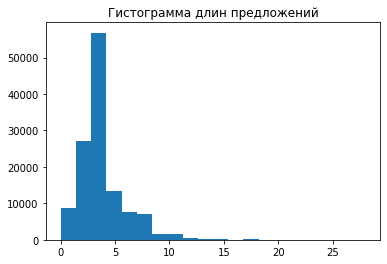

In [7]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

- создаем объекты датасетов `PaddedSequenceDataset`:
    - выдают объекты-тензоры для заданного текста, которые подаются в нейросеть
    - нужны для эффективной пакетной обработки, чтобы можно было параллельно обрабатывать на GPU
    - модели могут работать только с тензорами, а тензор — это такая "прямоугольная" конструкция, она не может иметь "неровный край"
    - в этой "подавалке" добавляются 0

`PaddedSequenceDataset`:
- может говорить свою длину (то есть, сколько предложений в нём есть, сколько текстов), 
- умеет возвращать предложение по номеру
    - если предложение короче некоторой заданной длины, то он добавляет нули в конец этого предложения
    - если предложение длиннее установленного порога, то он его обрезает, то есть берёт только префикс предложения

Эта функция возвращает пары — а именно "текст" и "какая-то метка", которую по этому тексту нужно предсказывать. Но в данной задаче мы метку не будем использовать.

\*) тут кстати было бы полезно использовать механизм протоколов, введенный в питоне 3.10 и поддержка которого появилась в торче 0.11.2, но на моем старичке GF760 ограничение sm_30 и торч 11 ему недоступен, именно поэтому пришлось компилировать питон 3.9 и торч с поддержкой sm_30.

In [8]:
# из гистограммы - это более менее норм порог, отбросится не много, нулей будет не много
MAX_SENTENCE_LEN = 20   

train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


### Видеокарты в вычислении

Видеокарты (это основные вычислители, которые сейчас используются для обучения нейросетей) умеют делать хорошо только достаточно простые операции, и, при этом, они умеют делать эти простые операции параллельно. 

Допустим, если нам нужно перемножить две матрицы, то в видеокарте запускается несколько тысяч потоков, каждый поток из этих тысяч, по сути, делает только 1-2 перемножения, и всё — и возвращает результат. При этом мы получаем очень большое ускорение. 

Но проблема в том, что данные исходные у нас не лежат на видеокарте, они лежат у нас во внешней памяти на жёстком диске. 

Сначала мы их загружаем с жёсткого диска в оперативную память, как-то предобрабатываем (например — так, как мы это сейчас обсудили), и только потом копируем в память видеокарты. Эта процедура копирования занимает значительное время. Это гораздо дороже, чем скопировать память внутри видеокарты или внутри оперативной памяти. 

И поэтому мы хотим минимизировать количество переносов данных из оперативной памяти в память видеокарты, и наоборот. Для этого нам нужно объединять наши обучающие примеры в батчи (в группы), и мы описываем нашу модель, наш процесс обучения, таким образом, чтобы он поддерживал обработку нескольких обучающих примеров за раз. 

Естественно, чем больше данных за раз мы загрузили в видеокарту, тем более эффективно мы можем использовать возможности параллельных вычислений. Все потоки будут хорошо загружены.

## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову.

Каждому слову сопоставлены 2 вектора (когда оно - центральное и когда оно - контекст). Для этого создает две матрицы W, D


$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

Условное распределение слов в окне (контекста), когда известно центральное слово (размер окна порядка 5 слов):

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

В общем виде почти не решается, берется предположение о независимости слов в контексте (для каждого слова смотрится отдельно встречаемость вместе с центральным словом, частоты (оценки вероятности) перемножаются): 

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$

**Negative Sampling** - аппроксимация softmax случайным подмножеством словаря

Софтмакс переводит вещественный вектор произвольного диапазона в [0,1] по типу сигмоиды (как бы у нас внутре нормальное распределение):
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

В софтмакс подаются оценки сходства слов, под которым понимаем скалярное произведение векторов этих слов ($w_i \cdot d_j$). 
Для центрального словая вектор берется из W, для контекстного - из D.

Проблема, в том, что сумма должна братся по очень большому числу слагаемых (по всему словарю). Вместо этого мы берем сумму по случайному подмножеству словаря - оцена остается несмещенной состоятельной, просто растет дисперсия оценки.

**Вспомогательная функция для создания матрицы маски окна**:
- модель принимает на вход целое предложение и должна оценивать вероятности встречаемости двух слов внутри небольшого окна
- нужно игнорировать факты совместной встречаемости слов в одном предложении, но — далеко друг от друга, за пределами окна
- сторона матрицы равна длине предложения, с которым мы работаем, все элементы в этой матрице — нулевые, за исключением двух полосок вдоль главной диагонали
- каждая строка маски - сдвиг окна и учет только тех слов, где стоит 1
- позволяет реализовать эффективную пакетную обработку на видеокарте

In [9]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

Короче говоря, **задача обучения word2vec** сводится к обучению классификатора, который, имея два идентификатора слова (два номера токена) предсказывает — могут они встретиться вместе, или не могут.

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [32]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        # хранение таблицы центральных векторов
        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0  # для фиктивного слова вес 0, т.е. он не будет меняться при обучении

        # хранение таблицы контекстных векторов
        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0 # для фиктивного слова вес 0, т.е. он не будет меняться при обучении
        
        # хранение маски
        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):   
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""

        # для кажого слова из пачки получаем центральные вектора
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        #   - для кажого слова из пачки получаем контекстные вектора, транспонируем (переставляем последние 2 измерения)
        #   - torch.bmm делает матричное умножение для каждой пары векторов слов в пачке -> 3d tensor
        #   - каждая матрица этого тензора - это оценка семантической близости этого слова с остальными в предложении
        #   - элементы матриц - скалярные произвидения центрального слова с остальными
        #       - на позиции ijk стоит оценка вероятности встретить k-е слово в контексте j-го слова в предложении i
        #   - torch.sigmoid - переводит эти матрицы в вероятности (по всем парам слов в данном предложении)
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        #   - с помощью маски отфильтровываем только те пары слов, которые встечаются в окнах
        #       - отправляем маску на устройство, и там множим поэлементно на матрицу вероятностей
        #   - считаем для полученных вероятностей функцию потерь, считая, что все ненулевые вероятности должны быть ==1
        #       - ...expand_as(positive_probs) - это как бы истинные метки классов (слова по факту встретились вместе)
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова (считаются отдельно, т.к. отрицательные слова - это то, чего в пачке нету)
        #   - torch.randint - случайные целые числа в заданном диапазоне (номера `отрицательных` токенов)
        #   - берем контекстные вектора этих токенов, аналогично транспонируем
        #   - аналогично перемножаем (получили семантическую близость случайных слов с центральными словами)
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        #   - считаем функцию потерь полагая, что истинная вероятность случайных слов ==0 (new_zeros)
        #   - _with_logits - позволяет не нормализовать оценки сходства (через сигмоиду, заменяющую софтмакс) 
        #       - результат примерно такой же, приводится как возможный вариант реализации
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

Некоторые особенности инициализации:
- по умолчанию `torch.nn.Embedding` заполняется нормальным шумом, для `word2vec` нужен равномерный шум:
    - почему? точно не понятно, скорее всего отголоски "проклятия размерности" - нормальный шум будет локализован в совсем маленьком гипершарике (тем меньше, чем больше размерность), а равномерный позволит охватить большее пространство, следовательно больший шанс что вектора в итоге скатяться по градиенту в больее глобальный минимум, но это только догадки...
    - диапазон шума - обратно пропорционально величине эмбеддинга (размерности вектора), просто эмпирически, чтобы не было больших значений и было мало нулей, которые при градиентном спуске часто дают небольшие локальные минимумы с маленьким градиентом, откуда долго выбираться

`forward` - традиционное название для метода получения предсказания от нейросетевой модели, но в данном случае он дает значение функции потерь, поэтому получается, что это у нас не модель, а просто алгоритм обучения (`...Trainer`)

В названии алгоритма есть слова "negative sampling", то есть сэмплирование отрицательных слов. Это достаточно буквальное название, то есть в качестве отрицательных слов мы выбираем случайные слова. В данном примере мы выбираем слова равномерно. В более продвинутых реализациях в качестве отрицательных слов используются более редкие слова, то есть сэмплирование уже идёт не равномерно, а с учётом частоты встречаемости каждого слова в обучающей выборке. Но, для простоты, мы опустим эти детали здесь. 
    

## Обучение

В экземпляр обучалки передаем
- длину словаря
- размер эмбеддингов, который мы строим
- максимальную длину предложний
- ширину окна
- количество негативных примеров для оценки отрицательных слов

Как мы выбираем размер эмбеддинга?

Можно лишь сказать, что это эвристический выбор. Лучше всего – по аналогии с другими работами... Ведь это как количество нейронов в сети: если взять недостаточно – потеряете в выразительности, если взять слишком много – будет очень долгий процесс обучения и, может быть, сеть станет словно база данных по обучающим примерами (переобучение).

In [11]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

Фиктивная функция потерь `no_loss` - модель сама считает функцию потерь

`ReduceLROnPlateau` - встроенный в торч метод изменения градиентного шага, заточен под залезание в минимумы типа "оврага"

\*) тут cuda всего лишь в 3 раза быстрее cpu

In [34]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=10, 
                                            batch_size=8,
                                            device='cuda',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 6.25 сек
Среднее значение функции потерь на обучении 0.8767410578696744
Среднее значение функции потерь на валидации 0.8786774248483904
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 6.05 сек
Среднее значение функции потерь на обучении 0.8775815696551882
Среднее значение функции потерь на валидации 0.8783538046117514
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 6.06 сек
Среднее значение функции потерь на обучении 0.8784560564158858
Среднее значение функции потерь на валидации 0.8776506648876733
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 7.18 сек
Среднее значение функции потерь на обучении 0.8771037552906
Среднее значение функции потерь на валидации 0.8776329918308926
Новая лучшая модель!

Эпоха 4
Эпоха: 2001 итераций, 6.74 сек
Среднее значение функции потерь на обучении 0.8767598694053547
Среднее значение функции потерь на валидации 0.8781076600191225
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 5
Эпоха: 2001 ит

все атрибуты объектов класса nn.Module, являющиеся наследниками Parameter доступны в методе nn.Module#parameters(). Более того, в этом методе доступны все parameters() других атрибутов-модулей. Достигается это посредством магического метода __setattr__. Звучит немного запутано, но на самом деле все просто. Ниже приведу код с примером.

    class ModuleA(nn.Module):
        def __init__(self):
            super().__init__()
            self.parameter_a = nn.Parameter(torch.tensor([5.0]))

    class ModuleB(nn.Module):
        def __init__(self):
            super().__init__()
            self.module_a = ModuleA()
            self.parameter_b = nn.Parameter(torch.tensor([5.0]))
            
    module_b = ModuleB()

    for name, param in module_b.named_parameters(recurse=True):
        print(name, param.size())

**Вывод программы:**

    >> parameter_b torch.Size([1])
    >> module_a.parameter_a torch.Size([1])

А в библиотеке nlpdlutils есть функция train_eval_loop. Так вот, эта функция использует тот самый метод parameters() для инициализации оптимизатора:

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)

Ну а дальше все очень просто. Вызывается метод, считающий градиенты для функции потерь по всем тензорам, в нее входящим:
    
    loss.backward()

И вызов 

    optimizer.step()

модифицирует model.parameters().

In [35]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), 'models/sgns.pth')

In [36]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

Это самописный класс `Embeddings` - набор методов для работы с эмбеддингами:
- главное - это вычисление близости векторов, но также есть:
    - получение списка векторов для слов 
    - поиск ближайшего по расстоянию на эмбеддингах слова
    - получение слов по семантическим переходам (сложение/вычитание эмбеддингов)

In [38]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

- слова близкие по смыслу слову "сыр"

In [39]:
embeddings.most_similar('chicken')

[('chicken', 0.99992704),
 ('stock', 0.60771614),
 ('beef', 0.57378614),
 ('turkey', 0.5708989),
 ('broth', 0.56518495),
 ('breasts', 0.52021),
 ('wings', 0.4902645),
 ('breast', 0.48436588),
 ('duck', 0.4801854),
 ('boneless', 0.4709255)]

- аналогии (семантические пропорции): какие слова относятся к слову "сыр" также как "какао" относится к "пирожное"
    - получилось плохо, потому что наверно рецептов сыра не было в обучающей выборке

- попробуем 'cake', 'milk', 'salad':
    - ну вот, уже проскакивают ингридиенты (оливки), хотя все равно ерунда

Говорят, обучающий корпус маловат...

In [40]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 0.97277063),
 ('cheese', 0.88818884),
 ('wafer', 0.6442452),
 ('shaved', 0.6350295),
 ('ricotta', 0.62190574),
 ('pecorino', 0.611588),
 ('gruyère', 0.6079014),
 ('grated', 0.59480953),
 ('goat', 0.5875807),
 ('grating', 0.5755977)]

In [70]:
embeddings.analogy('cake', 'dough', 'salad')

[('salad', 1.1103659),
 ('dough', 0.8153187),
 ('mesclun', 0.5383432),
 ('mache', 0.53411186),
 ('fluffy', 0.532677),
 ('dessert', 0.50992554),
 ('galette', 0.50342476),
 ('above', 0.4866662),
 ('southern', 0.48505527),
 ('manila', 0.47857425)]

- вектора нескольких слов 
- вектора размерности 100 переводятся в 2d TSNE из sklearn (T-distributed Stochastic Neighbor Embedding)
    - отражает похожесть между объектами пространства высокой размерности
    - близкие многомерные объекты казываются близкими на плоскости

In [41]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


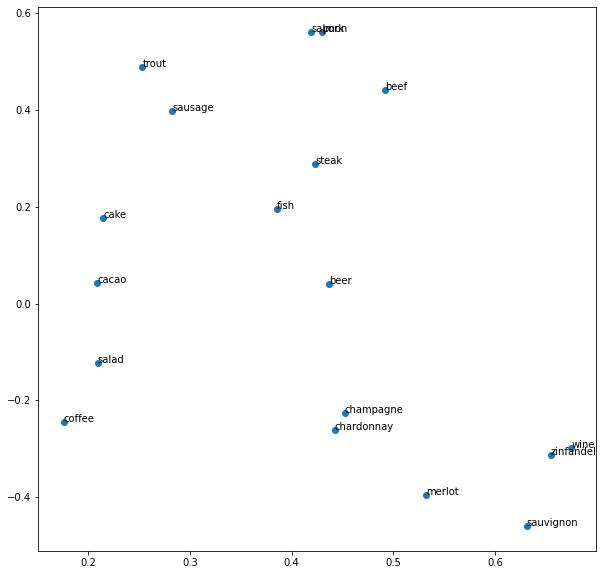

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

Аглоритм word2vec не детерминирован (случайные негитивные примеры, случайный шум при инициализации), картинки будет разными, но должна сохраняться общая картина (по идее).

Это была собственная реализации word2vec.

## Обучение Word2Vec с помощью Gensim

Одна из лучших библиотек для word2vec моделей.

In [43]:
import gensim

In [44]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

- Оценки сходства и набор ближайщих слов отличается, но не кардинально.

In [71]:
word2vec.wv.most_similar('cheese')

[('salata', 0.8112857937812805),
 ('pecorino', 0.7634388208389282),
 ('queso', 0.7589499950408936),
 ('gruyere', 0.755763053894043),
 ('fontina', 0.7476573586463928),
 ('monterey', 0.7470556497573853),
 ('feta', 0.7411114573478699),
 ('cheddar', 0.7345227003097534),
 ('fresco', 0.7320069670677185),
 ('jack', 0.7278673648834229)]

In [46]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

- На плоскости все вообще по-другому, кластеры выделяются более четко и осмысленно.

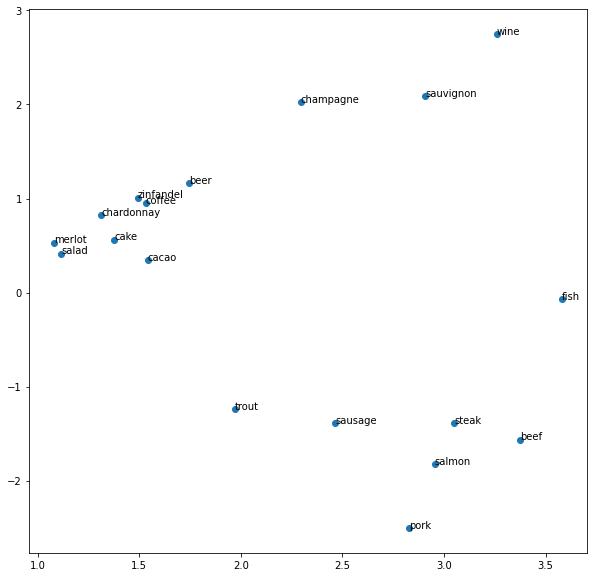

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Подготовка текстов - сложная задача, обычно используются хорошо подготовленные языковые наборы данных, или уже обученные модели.

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [48]:
import gensim.downloader as api

api.BASE_DIR

'/home/user1/gensim-data'

В gensim есть несколько предобученных эмбеддингов, которые можно просто скачать.

In [49]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


Правда уже после скачивания он опять чето очень долго возится (почти 3 минуты, а качал минут 10 если не больше)

In [50]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB! архив, 3.5 Gb в памяти
# чего он так долго не понятно, все же загруженов BASE_DIR

- совсем другая история с похожими словами
    - модель обучалась не на рецептах, а на новостях
    - при обучении использовались не только слова, но и биграммы слов (вектора строились и для пар тоже)
        - наверно это было долгое обучение

In [51]:
pretrained.most_similar('cheese')

[('cheeses', 0.7789000272750854),
 ('cheddar', 0.7627596855163574),
 ('goat_cheese', 0.7297402620315552),
 ('Cheese', 0.7286962866783142),
 ('cheddar_cheese', 0.7255136966705322),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805709600448608),
 ('cheddar_cheeses', 0.6694672703742981),
 ('Camembert', 0.6623163223266602),
 ('gruyere', 0.6615148186683655)]

- Какое слово относится к слову `queen` также, как `man` к `king`
    - получилось

In [52]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077576637268066),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696184158325195),
 ('person', 0.48637545108795166)]

#### Визуализируем эмбеддинги из этой гигантской модели

In [53]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

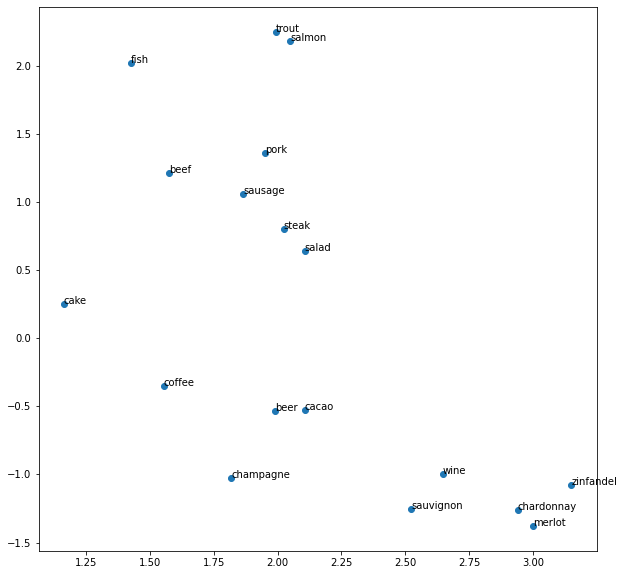

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

Часто для обучения больших моделей тексты не разбивают на предложения, а рассматривают весь текст как единую последовательность токенов.

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают

Большая модель неплохо аппроксимирует не только близость слов, но и какие-то семантические отношения, то есть уже как-то решает смысловые пропорции.


Норм, было интересно!

# До.за.

В качестве домашнего задания мы предлагаем Вам поэкспериментировать с кодом этого семинара, чтобы лучше понять свойства эмбеддингов и попробовать улучшить их качество. Что можно попробовать сделать:

- поиграться с параметрами - количеством отрицательных слов, размером батча, скоростью обучения, размером окна
- убрать разбиение текстов на предложения и увеличить окно
- изменить токенизацию, например, разобравшись с библиотекой SpaCy и подключив лемматизацию и POS-теггинг, чтобы строить эмбеддинги не для словоформ, а для лемм (например, chicked_NOUN)
- реализовать FastText и сравнить, как отличаются списки похожих документов, получаемых с помощью Word2Vec и FastText
- усложнить алгоритм оценки вероятности совместной встречаемости слов, например, заменив скалярное произведение на нейросеть с парой слоёв

Также мы предлагаем Вам не ограничиваться этим списком, а придумать свои способы заставить Word2Vec выучить что-то интересное и полезное.

**Может быть, будет интересно попробовать побить нашу функцию потерь на валидации, там она равнялась $\sim 0,87$**

Потому, что эмбеддинги - это обучение без учителя (вернее, **self-supervised learning**). Когда мы строим какие-то эмбеддинги, мы можем не думать ни о какой одной конкретной задаче, на которой они будут использоваться - в этом случае мы можем использовать датасет сильно большего размера, чем существует для каждой конкретной задачи.

Часто всё-таки качество эмбеддингов оценивают опосредовано, подкладывая эти эмбеддинги в некоторую зафиксированную архитектуру, и меряя качество решения другой задачи (например, классификации или извлечения сущностей). При этом архитектура этой "прикладной" нейросети зафиксирована, но веса переобучаются заново для каждых каждых эмбеддингов. Такая идея реализована в библиотеке для сравнения эмбеддингов [Vecto](https://github.com/vecto-ai/vecto).

План self-supervised learning студента:

- трогать словарь (проги редких/частных) интуитивно кажется смысла особого нет
    - словарь и так небольшой

- чисто интуитивно:
    - размер эмбеддинга x1.5 (вместит больше информации, но и шума)
    - окно +2 (ловим смысловую связь более разнесенных слов)
    - отрицательные слова x2 (вычислительно хуже, до дисперсия бустинга меньше)
    - размер батча x1.5 (вычислительно хуже, но градиент точнее)

- в результате: 
    - функция потерь хуже (мы добавили много шума)
    - близкие слова очень похожи, просто в другом порядке (на примере chicken)
    - семантические связи выглядят похуже (cake - dough = salad - X)
    - время эпохи на GPU увеличилось на 10-15%

In [87]:
trainer1 = SkipGramNegativeSamplingTrainer(len(vocabulary), 150, MAX_SENTENCE_LEN,
                                           radius=7, negative_samples_n=50)

best_val_loss, best_model = train_eval_loop(trainer1,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=10,
                                            batch_size=12,
                                            device='cuda',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 6.74 сек
Среднее значение функции потерь на обучении 0.9804894695396366
Среднее значение функции потерь на валидации 0.9731077978939571
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 6.93 сек
Среднее значение функции потерь на обучении 0.9715297589714321
Среднее значение функции потерь на валидации 0.9694536443610848
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 6.42 сек
Среднее значение функции потерь на обучении 0.9691138848074075
Среднее значение функции потерь на валидации 0.9689396586246674
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 6.41 сек
Среднее значение функции потерь на обучении 0.9679077305178949
Среднее значение функции потерь на валидации 0.969269894118391

Эпоха 4
Эпоха: 2001 итераций, 6.13 сек
Среднее значение функции потерь на обучении 0.9679128329257022
Среднее значение функции потерь на валидации 0.9694769287018843
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 5
Эпоха: 2001 итераций, 6.24 сек
Ср

In [88]:
embeddings1 = Embeddings(trainer1.center_emb.weight.detach().cpu().numpy(), vocabulary)


print(*[word for (word, _) in embeddings.most_similar('chicken')])
print(*[word for (word, _) in embeddings1.most_similar('chicken')])

chicken stock beef turkey broth breasts wings breast duck boneless
chicken stock thighs duck beef broth turkey breasts veal boneless


In [89]:
print(*[word for (word, _) in embeddings.analogy('cake', 'dough', 'salad')])
print(*[word for (word, _) in embeddings1.analogy('cake', 'dough', 'salad')])

salad dough mesclun mache fluffy dessert galette above southern manila
salad dough lettuce vinaigrette tendrils mache mesclun dressing ingredients refrigerator


- в обратную сторону:
    - размер эмбеддинга x0.7 (вместит меньше информации, но и меньше шума)
    - окно -2 (интересуют только совсем близкие слова)
    - отрицательные слова x2 (вычислительно хуже, до дисперсия бустинга меньше)
    - размер батча x0.7 (больше случайности в поиске минимума)

- в результате: 
    - функция потерь лучше (мы убрали много шума)
    - близкие слова стали менее осмысленными (на примере chicken)
    - семантические связи выглядят похуже (cake - dough = salad - X)

In [90]:
trainer2 = SkipGramNegativeSamplingTrainer(len(vocabulary), 70, MAX_SENTENCE_LEN,
                                           radius=3, negative_samples_n=50)

best_val_loss, best_model = train_eval_loop(trainer2,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=10,
                                            batch_size=12,
                                            device='cuda',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 6.14 сек
Среднее значение функции потерь на обучении 0.7752328028326211
Среднее значение функции потерь на валидации 0.7673968376659618
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 6.11 сек
Среднее значение функции потерь на обучении 0.7660037739046927
Среднее значение функции потерь на валидации 0.764593088136924
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 6.17 сек
Среднее значение функции потерь на обучении 0.7636679580722792
Среднее значение функции потерь на валидации 0.7638303677045742
Новая лучшая модель!

Эпоха 3
Эпоха: 2001 итераций, 6.50 сек
Среднее значение функции потерь на обучении 0.7634968111242192
Среднее значение функции потерь на валидации 0.7637243535680006
Новая лучшая модель!

Эпоха 4
Эпоха: 2001 итераций, 6.35 сек
Среднее значение функции потерь на обучении 0.7624708095352272
Среднее значение функции потерь на валидации 0.7635274325227641
Новая лучшая модель!

Эпоха 5
Эпоха: 2001 итераций, 6.01 сек
Среднее значение функц

In [91]:
embeddings2 = Embeddings(trainer2.center_emb.weight.detach().cpu().numpy(), vocabulary)


print(*[word for (word, _) in embeddings.most_similar('chicken')])
print(*[word for (word, _) in embeddings2.most_similar('chicken')])

chicken stock beef turkey broth breasts wings breast duck boneless
chicken thighs stock turkey breasts duck broth beef breast boneless


In [92]:
print(*[word for (word, _) in embeddings.analogy('cake', 'dough', 'salad')])
print(*[word for (word, _) in embeddings2.analogy('cake', 'dough', 'salad')])

salad dough mesclun mache fluffy dessert galette above southern manila
salad dough above southern various basic california frisée mache greens


#### FastText

- реализовывать пока не будем

- считает быстро
- близкие слова и семантика сильно хуже, но они все равно заметны

In [93]:
fastText = gensim.models.FastText(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [99]:
print(*[word for (word, _) in embeddings.most_similar('chicken')])
print(*[word for (word, _) in fastText.wv.most_similar('chicken')])

chicken stock beef turkey broth breasts wings breast duck boneless
chickens chick duck drumstick thighs thigh drumsticks rabbit turkey legs


In [100]:
print(*[word for (word, _) in embeddings.analogy('cake', 'dough', 'salad')])
print(*[word for (word, _) in fastText.wv.most_similar(positive=['cake', 'salad'], negative=['dough'])])

salad dough mesclun mache fluffy dessert galette above southern manila
mesclun arugula frisée various frisee purslane mizuna wildflower dandelion treviso
